In [1]:
# general modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob
from os.path import join

# modules for loading pupil data
import pickle
import pyedfread as edf

# module for preprocessing steps
from PSPupil import Preprocessing as PS

## Prerequesites

pyedfread: download from here: https://github.com/nwilming/pyedfread
PSPupil 

## 0. Make 'PupilFrame' object to use functionality from PSPupil preprocessing script

In [106]:
sub = '099'
run = '009'
pp = PS.PupilFrame(sub, 'molly', 'Baseline', run, directory='')

## 1. Load pupil data and bring into data structure

In [6]:
path = '/Volumes/psp_data/Lisa_Marc/2018_02_08_PSP_001_Baseline/000/pupil_data'

In [7]:
with open(path, 'rb') as f:
    file = pickle.load(f, encoding='latin-1')

In [27]:
# get pupil diameter per side

df = pd.DataFrame(file['pupil_positions'])

pupil_left = df.loc[df.id == 1].drop(['norm_pos', 'ellipse', 'method'], axis=1)
pupil_right = df.loc[df.id == 0].drop(['norm_pos', 'ellipse', 'method'], axis=1)

#plt.plot(pupil_right.diameter.values)

In [43]:
# get gaze directions 

gaze = pd.DataFrame(file['gaze_positions'])
gaze[['x', 'y']] = pd.DataFrame(gaze['norm_pos'].to_list(), index = gaze.index)
gaze = gaze.loc[:, ['x', 'y', 'timestamp']]

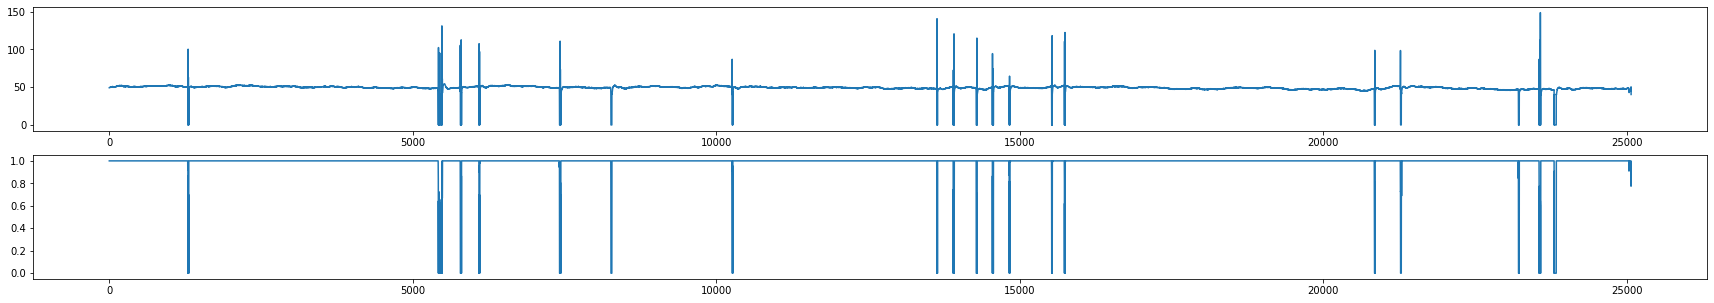

In [50]:
f, ax = plt.subplots(2, 1, figsize=(30, 5))

ax[0].plot(pupil_right.diameter.values)

ax[1].plot(pupil_right.confidence.values)

## 2. Determine better side and resample
- pragmatisch: use pupil side with higher percentage of data points above arbitrary "confidence" threshold

In [56]:
confidence_threshold = 0.9
pupil_right['data_quality'] = pupil_right.confidence > confidence_threshold
print('right', pupil_right.data_quality.mean())

confidence_threshold = 0.9
pupil_left['data_quality'] = pupil_left.confidence > confidence_threshold
print('left', pupil_left.data_quality.mean())


right 0.9854835493519442
left 0.978383983409109


In [58]:
pupil_data = pupil_right

In [71]:
time_zero = np.min([gaze.iloc[0].timestamp, pupil_data.iloc[0].timestamp])
pupil_data['time'] = np.round(((pupil_data.timestamp - time_zero) *1000))
pupil_data = pupil_data.set_index(pd.to_datetime(pupil_data['time'], unit='ms'))
pupil_data = pupil_data.resample('ms').mean().interpolate('linear')
pupil_data = pupil_data.resample('17ms').mean()


gaze['time'] = np.round(((gaze.timestamp - time_zero) *1000))
gaze = gaze.set_index(pd.to_datetime(gaze['time'], unit='ms'))
gaze = gaze.resample('ms').mean().interpolate('linear')
gaze = gaze.resample('17ms').mean()

In [76]:
pupil_gaze = pd.concat([gaze, pupil_data], axis=1).drop(['timestamp', 'id'], axis=1)

In [77]:
pupil_gaze

,x,y,time,diameter,confidence,data_quality,time
time,,,,,,,
1970-01-01 00:00:00.000,0.404997,0.350131,8.0,49.271112,1.000000,1.000000,12.5
1970-01-01 00:00:00.017,0.405889,0.346876,25.0,49.281803,1.000000,1.000000,25.0
1970-01-01 00:00:00.034,0.406518,0.352122,42.0,49.378101,1.000000,1.000000,42.0
1970-01-01 00:00:00.051,0.408549,0.359459,59.0,49.576787,1.000000,1.000000,59.0
1970-01-01 00:00:00.068,0.407423,0.348697,76.0,49.762603,1.000000,1.000000,76.0
...,...,...,...,...,...,...,...
1970-01-01 00:03:30.766,0.526204,0.269484,210774.0,46.837200,1.000000,1.000000,210774.0
1970-01-01 00:03:30.783,0.456470,0.237642,210791.0,46.376376,0.998172,1.000000,210791.0
1970-01-01 00:03:30.800,0.357088,0.050607,210808.0,45.950262,0.971773,0.941380,210808.0


## 3. Cut 
- discard first 5s and ending such by slicing [5:210]


In [80]:
pupil_gaze = pupil_gaze.loc[pd.Timestamp(5, unit='s'):pd.Timestamp(210, unit='s')]

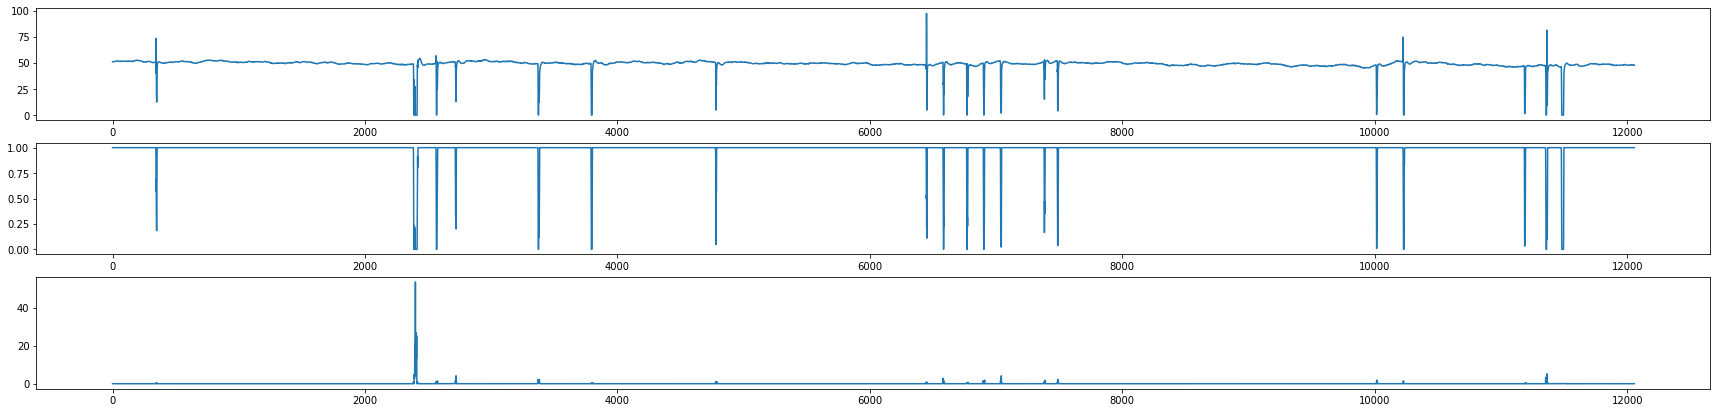

In [109]:
f, ax = plt.subplots(3, 1, figsize=(30, 7))

ax[0].plot(pupil_gaze.diameter.values)

ax[1].plot(pupil_gaze.confidence.values)

ax[2].plot(pupil_gaze.acceleration.values)


In [110]:
pupil_gaze.acceleration

time
1970-01-01 00:00:05.015   -0.049794
1970-01-01 00:00:05.032   -0.050601
1970-01-01 00:00:05.049   -0.050495
1970-01-01 00:00:05.066   -0.050495
1970-01-01 00:00:05.083   -0.050620
                             ...   
1970-01-01 00:03:29.916   -0.051174
1970-01-01 00:03:29.933   -0.051174
1970-01-01 00:03:29.950   -0.051818
1970-01-01 00:03:29.967   -0.051050
1970-01-01 00:03:29.984   -0.049794
Freq: 17L, Name: acceleration, Length: 12058, dtype: float64

## 4. Calculate Gaze velocity & acceleration

In [104]:
x_diff = pupil_gaze.x.values - np.roll(pupil_gaze.x.values, 1)
x_diff[0] = 0

y_diff = pupil_gaze.y.values - np.roll(pupil_gaze.y.values, 1)
y_diff[0] = 0

pupil_gaze.loc[:, 'distance'] =\
    np.sqrt(np.square(x_diff) + np.square(y_diff))


pupil_gaze.loc[:, 'velocity'] = PS.derivative(pupil_gaze, 'distance')
pupil_gaze.loc[:, 'acceleration'] = PS.derivative(pupil_gaze, 'velocity')
pupil_gaze.loc[:, 'acceleration'] = (pupil_gaze.loc[:, 'acceleration'] - pupil_gaze.loc[:, 'acceleration'].mean()) / pupil_gaze.loc[:, 'acceleration'].std()


/Users/kenohagena/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/kenohagena/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [108]:
new_cols = {'diameter': 'diameter_mean',
                'confidence': 'confidence_d'}

pp.gp = pupil_gaze.rename(columns=new_cols)


## 5. Interpolate and inspect visually

In [112]:
confidence_thresh = 0.9
excel_thresh = 1
islands = 5
margin1=5
margin2=5

pp.discard_interp_(excel_thresh=excel_thresh, confidence_thresh=confidence_thresh,
                     islands=islands, margin2=margin2, margin1=margin1)


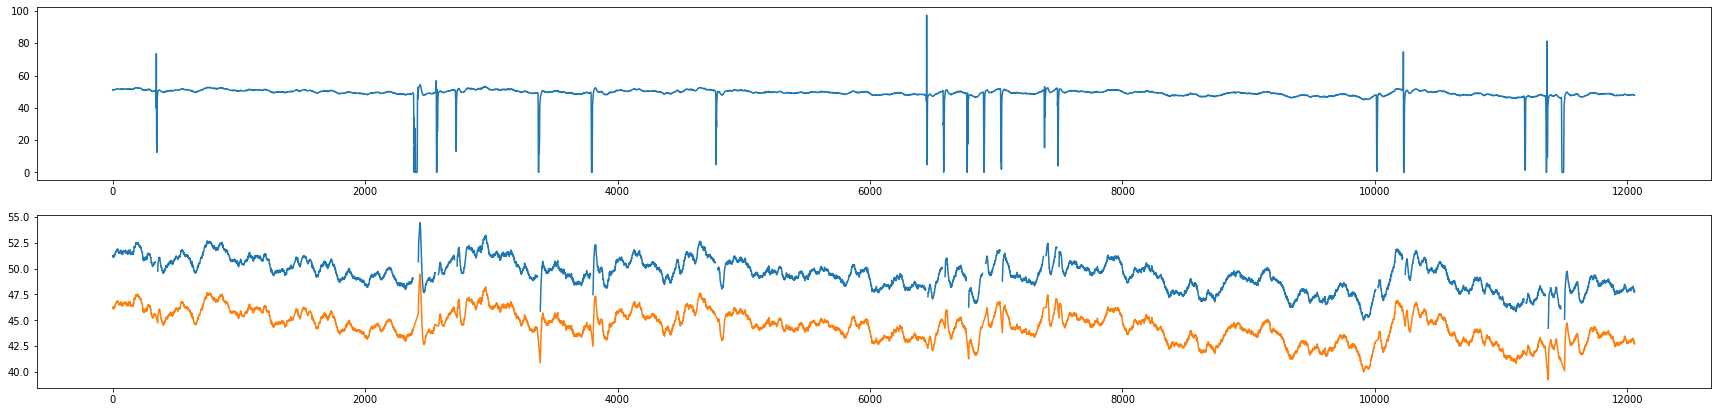

In [118]:
f, ax = plt.subplots(2, 1, figsize=(30, 7))

ax[0].plot(pp.gp.diameter_mean.values)

ax[1].plot(pp.gp.diameter_blink.values)
ax[1].plot(pp.gp.d_intp.values - 5)



0.9


(0, 100)

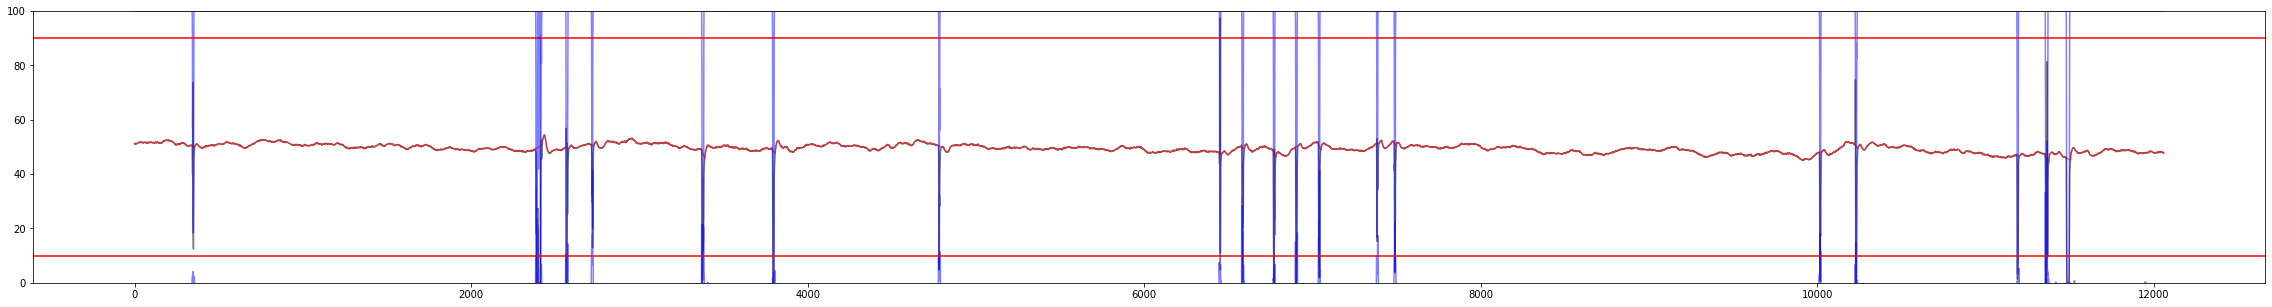

In [134]:
f, ax = plt.subplots(figsize=(40, 5))
ax.plot(pp.gp.diameter_mean.values, color='black', alpha=.5)
ax.plot(pp.gp.d_intp.values, color='red', alpha=.5)

ax.plot(pp.gp.confidence_d.values*100, color='blue', alpha=.5)
ax.axhline(confidence_thresh*100, color='red')
print(confidence_thresh)


ax.plot(pp.gp.acceleration.values *10, color='blue', alpha=.5)
ax.axhline(excel_thresh*10, color='red')
ax.set_ylim(0, 100)


## 6. Normalize and save
- z-scoring

In [135]:
pp.gp['pupil_intp_z'] = (pp.gp['d_intp'] - pp.gp['d_intp'].mean()) / pp.gp['d_intp'].std()

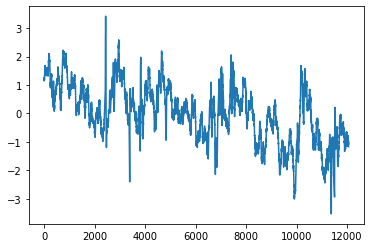

In [136]:
plt.plot(pp.gp['pupil_intp_z'].values)

In [139]:
pp.gp.drop('time', axis=1).to_hdf('/Users/kenohagena/Desktop/test.hdf', key='test')

In [140]:
new_df= pd.read_hdf('/Users/kenohagena/Desktop/test.hdf', key='test')

In [141]:
new_df

,x,y,diameter_mean,confidence_d,data_quality,distance,velocity,acceleration,diameter_blink,margin,islands,d_intp,pupil_intp_z
time,,,,,,,,,,,,,
1970-01-01 00:00:05.015,0.408201,0.480099,51.164300,1.0,1.0,0.000000,0.007474,-0.049794,51.164300,True,True,51.164300,1.189651
1970-01-01 00:00:05.032,0.409340,0.487486,51.256538,1.0,1.0,0.007474,0.007474,-0.050601,51.256538,True,True,51.256538,1.252611
1970-01-01 00:00:05.049,0.407098,0.485081,51.289583,1.0,1.0,0.003288,0.004186,-0.050495,51.289583,True,True,51.289583,1.275167
1970-01-01 00:00:05.066,0.408271,0.488294,51.260531,1.0,1.0,0.003420,0.000618,-0.050495,51.260531,True,True,51.260531,1.255337
1970-01-01 00:00:05.083,0.405983,0.489914,51.169692,1.0,1.0,0.002803,0.003858,-0.050620,51.169692,True,True,51.169692,1.193331
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:03:29.916,0.479657,0.521926,47.884522,1.0,1.0,0.003783,0.002299,-0.051174,47.884522,True,True,47.884522,-1.049075
1970-01-01 00:03:29.933,0.480586,0.523083,47.973657,1.0,1.0,0.001484,0.004082,-0.051174,47.973657,True,True,47.973657,-0.988233
1970-01-01 00:03:29.950,0.480855,0.528642,47.990906,1.0,1.0,0.005565,0.004172,-0.051818,47.990906,True,True,47.990906,-0.976459
